In [1]:
from __future__ import division, print_function

In [2]:
import sys
sys.path.append('./')
import os.path

In [4]:
import numpy as np
from plot import plot_det, plot_fit
import matplotlib.pyplot as plt
from common import basecolors, lightcolors, darkcolors
from common import num_representation, safe_num_representation_max
from common import OrganNames, A0s, taus, DetNames, MCout 
from common import activity, det_response_teo, det_contributions, det_response
from common import det_matrix_smear as det_response_smear

In [5]:
from smearing_common import times, CPSall, errCPSall
from smearing_common import widthsMatrix as widths

In [6]:
taus

array([252.37945966,  16.29632229,  13.7144127 ,   9.74447082,
        30.78589688,  22.53539562])

In [7]:
processed_lists = np.load('smearingMatrix.npy',allow_pickle=True)

In [8]:
for i, processed_list in enumerate(processed_lists):
    print("len(processed_list)",len(processed_list))
    for n, res_Nelder in enumerate(processed_list):
        if i==0 and n==0 :
            print("i:",i)
            #print(res_Nelder)
            print(type(res_Nelder))
            print(res_Nelder.x)

len(processed_list) 100
i: 0
<class 'scipy.optimize.optimize.OptimizeResult'>
[7.50838382e+08 1.12898664e+08 1.04314193e+08 3.49652047e+07
 1.11457395e+09 1.30780350e+08 2.51293920e+02 1.65035555e+01
 1.38552856e+01 9.74034534e+00 3.07798811e+01 2.22029585e+01]
len(processed_list) 100
len(processed_list) 100
len(processed_list) 100
len(processed_list) 100
len(processed_list) 100
len(processed_list) 100
len(processed_list) 100


In [9]:
x = np.concatenate((A0s,taus)) 
tin = times[0]
tfin = times[-1]
AttTrue = A0s*taus*(np.exp(-tfin/taus)-np.exp(-tin/taus))

residuiA0_means = np.empty(shape=(len(widths),len(A0s)))
residuiA0_vars = np.empty(shape=(len(widths),len(A0s)))
residuiTau_means = np.empty(shape=(len(widths),len(taus)))
residuiTau_vars = np.empty(shape=(len(widths),len(taus)))
Att_means = np.empty(shape=(len(widths),len(A0s)))
Att_vars = np.empty(shape=(len(widths),len(A0s)))
#residui = np.empty(shape=(len(widths),len(A0)+len(tau))
for i, processed_list in enumerate(processed_lists): #loop sulla percentuale di semaring
    res_chisq = np.empty(len(processed_list))
    residui = np.empty(shape=(len(processed_list),len(A0s)+len(taus)))
    Att = np.empty(shape=(len(processed_list),len(A0s)))
    for n, res_Nelder in enumerate(processed_list): #loop sui tentativi di fit per ogni smearing
        #print("i:",i,"n:",n)
        residui[n] = (res_Nelder.x-x)/x*100
        A = res_Nelder.x[:6]
        tau = res_Nelder.x[6:] 
        tmp = (A*tau*(np.exp(-tfin/tau)-np.exp(-tin/tau)))
        Att[n] = (tmp - AttTrue)/AttTrue*100
        #print("residui",residui,"%")
    #print("################","end loop","#################")    

    for j in range(len(A0s)):
        residuiA0_means[i][j] = np.mean(residui[:,j])
        residuiA0_vars[i][j] = np.std(residui[:,j])
        residuiTau_means[i][j] = np.mean(residui[:,j+len(A0s)])
        residuiTau_vars[i][j] = np.std(residui[:,j+len(A0s)])
        Att_means[i][j] = np.mean(Att[:,j])
        Att_vars[i][j] = np.std(Att[:,j])        

Text(0.5, 0, 'Smearing half-width [%]')

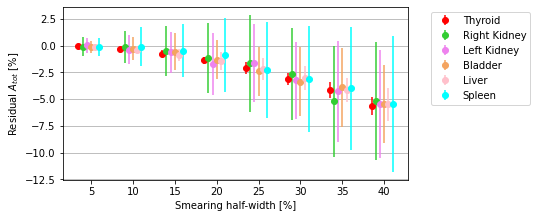

In [10]:
fig1 = plt.figure(1)
frame1=fig1.add_axes((.1,.71,.8,.6))
for j in range(len(A0s)):
    x = np.asarray(widths)*100
    x = x+j/2-len(A0s)/4
    plt.errorbar(x, Att_means[:,j], Att_vars[:,j], None, 'o', label=OrganNames[j],color=lightcolors[j])
#plt.ylim(-100,100)
plt.grid(axis='y')
#plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gca().set_ylabel(r'Residual $A_{tot}$ [%]')
plt.gca().set_xlabel("Smearing half-width [%]")

Text(0.5, 0, 'Smearing half-width [%]')

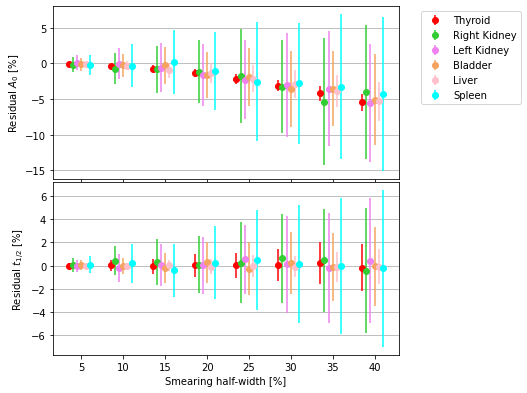

In [12]:
fig1 = plt.figure(1)
frame1=fig1.add_axes((.1,.71,.8,.6))
for j in range(len(A0s)):
    xx = np.asarray(widths)*100
    xx = xx+j/2. - len(A0s)/4
    plt.errorbar(xx, residuiA0_means[:,j], residuiA0_vars[:,j], None, 'o', label=OrganNames[j],color=lightcolors[j])
#plt.ylim(-50,50)
#plt.ylim(-300,1300)
plt.grid(axis='y')
#plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gca().set_ylabel(r'Residual $A_0$ [%]')

frame2=fig1.add_axes((.1,.1,.8,.6))      
for j in range(len(taus)):
    xx = np.asarray(widths)*100
    xx = xx+j/2. - len(A0s)/4
    residuiT12_means = residuiTau_means[:,j]*np.log(2.)
    residuiT12_vars = residuiTau_vars[:,j]*np.log(2.)
    plt.errorbar(xx, residuiT12_means, residuiT12_vars, None, 'o', label=OrganNames[j],color=lightcolors[j])
#plt.ylim(-50,50)
#plt.ylim(-300,1300)
plt.grid(axis='y')
#plt.yscale('log')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gca().set_ylabel(r'Residual $t_{1/2}$ [%]')
plt.gca().set_xlabel("Smearing half-width [%]")

In [13]:
residuiA0_means.shape

(8, 6)

In [14]:
#df = pd.DataFrame(data=np.array([residuiA0_means, residuiA0_vars,residuiT12_means,residuiT12_vars]), 
#                  columns=["A0means", "A0std","t12means","t12std"], 
#                  index=OrganNames)

RMS 11.209997583102298


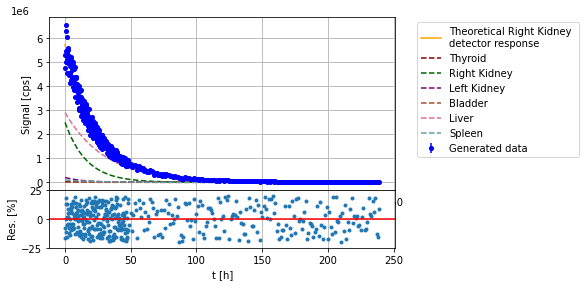

In [15]:
plot_det(2, times, A0s,taus, MCout, CPSall, ylim=(-25,25))

In [14]:
processed_lists[4][0] 

 final_simplex: (array([[7.33622339e+08, 1.10476948e+08, 9.65770030e+07, 3.40196491e+07,
        1.10429811e+09, 1.20988426e+08, 2.51114530e+02, 1.69469974e+01,
        1.40986157e+01, 9.78476929e+00, 3.03019497e+01, 2.33564743e+01],
       [7.33622339e+08, 1.10476948e+08, 9.65770030e+07, 3.40196491e+07,
        1.10429811e+09, 1.20988426e+08, 2.51114530e+02, 1.69469974e+01,
        1.40986157e+01, 9.78476929e+00, 3.03019497e+01, 2.33564743e+01],
       [7.33622339e+08, 1.10476948e+08, 9.65770030e+07, 3.40196491e+07,
        1.10429811e+09, 1.20988426e+08, 2.51114530e+02, 1.69469974e+01,
        1.40986157e+01, 9.78476929e+00, 3.03019497e+01, 2.33564743e+01],
       [7.33622339e+08, 1.10476948e+08, 9.65770030e+07, 3.40196491e+07,
        1.10429811e+09, 1.20988426e+08, 2.51114530e+02, 1.69469974e+01,
        1.40986157e+01, 9.78476929e+00, 3.03019497e+01, 2.33564743e+01],
       [7.33622339e+08, 1.10476948e+08, 9.65770030e+07, 3.40196491e+07,
        1.10429811e+09, 1.20988426e+08, 2.5

RMS 12.701596824546625


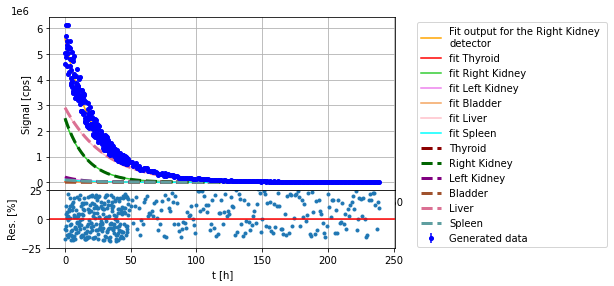

In [15]:
#il primo numero e' per decidere quale larghezza di campionamento prendere per il plot 
fit_output = processed_lists[4][0] 
plot_fit(2,fit_output, times, A0s, taus, MCout, CPSall, ylim=(-25,25))

RMS 12.701596824546625


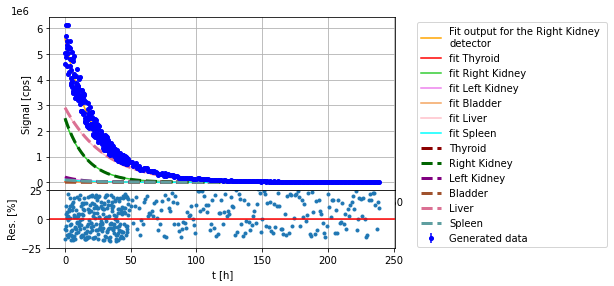

In [16]:
#il primo numero e' per decidere quale larghezza di campionamento prendere per il plot 
fit_output = processed_lists[4][0] 
plot_fit(2,fit_output, times, A0s, taus, MCout, CPSall, ylim=(-25,25))

RMS 13.270282884621052


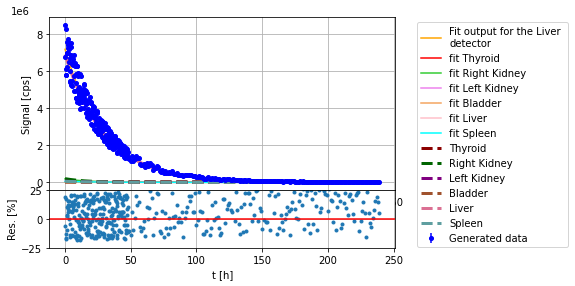

In [17]:
#il primo numero e' per decidere quale larghezza di campionamento prendere per il plot 
fit_output = processed_lists[4][0] 
plot_fit(5,fit_output, times, A0s, taus, MCout, CPSall, ylim=(-25,25))

RMS 11.847488847629858


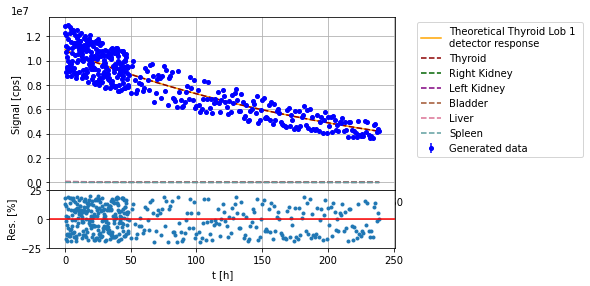

In [18]:
plot_det(0, times, A0s,taus, MCout, CPSall, ylim=(-25,25))

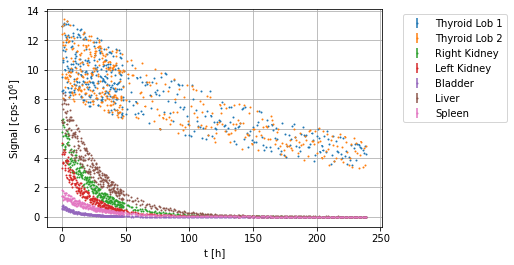

In [19]:
for i in range(len(DetNames)):
    y = det_response_smear(times,A0s,taus,i,.25)
    plt.errorbar(times, y/1.e+6, np.sqrt(y)/1.e+6,None, 'o', markersize=1, label=DetNames[i])
plt.xlabel('t [h]')
plt.ylabel(r'Signal [cps$\cdot 10^{6}$]')
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')